# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [5]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
import lzma
import numpy as np
import gymnasium as gym
import serde.json
import typing
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

from utils.env import State, Observation, Action, state_batch_to_tensor, action_batch_to_tensor, obs_batch_to_tensor, get_metadrive_state, next_state, normalize_angle
from utils.model import deviceof
from utils.in_memory_scenario_env import InMemoryScenarioEnv
from utils.loader import getFiles, fullPath
from utils.waymo_loader import extract_scenarios_file
from utils.scenario_converter import extract_trajectory
from utils.idm_model_def import InverseDynamicsModel
from utils.scenario import Scenario


from torch.utils.data import TensorDataset, DataLoader
import itertools
import matplotlib.pyplot as plt

# CHANGE ME: Set this to the path to the Waymo Open Dataset root directory
WAYMO_DATA_PATH = "~/data/waymo"
DEST_DATA_PATH = "~/data/waymo_scenarios"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
for scenarios_in_file in map(extract_scenarios_file, getFiles(WAYMO_DATA_PATH)):
    print(f"Loaded {len(scenarios_in_file)} scenarios.")
    for scenario in scenarios_in_file:
        with open(fullPath(f"{DEST_DATA_PATH}/{scenario.scenario_id}.json"), "w") as f:
            f.write(serde.json.to_json(scenario))

2023-09-17 09:46:58.609997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 09:46:58.629212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 09:46:58.629479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loaded 61 scenarios.
Loaded 72 scenarios.
Loaded 64 scenarios.
Loaded 65 scenarios.
Loaded 65 scenarios.
Loaded 84 scenarios.
Loaded 68 scenarios.
Loaded 65 scenarios.
Loaded 57 scenarios.
Loaded 58 scenarios.
Loaded 72 scenarios.
Loaded 60 scenarios.
Loaded 71 scenarios.
Loaded 66 scenarios.
Loaded 67 scenarios.
Loaded 68 scenarios.
Loaded 90 scenarios.
Loaded 55 scenarios.
Loaded 71 scenarios.
Loaded 75 scenarios.
Loaded 67 scenarios.
Loaded 67 scenarios.
Loaded 75 scenarios.
Loaded 77 scenarios.
Loaded 67 scenarios.
Loaded 68 scenarios.
Loaded 63 scenarios.
Loaded 87 scenarios.
Loaded 73 scenarios.
Loaded 64 scenarios.
Loaded 64 scenarios.
Loaded 57 scenarios.
Loaded 75 scenarios.
Loaded 76 scenarios.
Loaded 75 scenarios.
Loaded 72 scenarios.
Loaded 68 scenarios.
Loaded 61 scenarios.
Loaded 66 scenarios.
Loaded 68 scenarios.
Loaded 88 scenarios.
Loaded 68 scenarios.
Loaded 81 scenarios.
Loaded 72 scenarios.
Loaded 70 scenarios.
Loaded 64 scenarios.
Loaded 69 scenarios.
Loaded 65 sce

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
idm = InverseDynamicsModel().to(device)
idm.load_state_dict(torch.load('./data/idm.pth'))    

FileNotFoundError: [Errno 2] No such file or directory: './data/idm.pth'

Let's try visualizing our IDM by having it follow a track from start to finish.

In [18]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return Action(steering.item(), throttle.item())


### Trajectory Replay

In [30]:
env = InMemoryScenarioEnv(config={"use_render": True, "manual_control": False})

In [ ]:
with open(getFiles(DEST_DATA_PATH)[0], "r") as f:
    scenario = serde.json.from_json(Scenario, f.read())
    trajectory = extract_trajectory(scenario.tracks[scenario.ego_track_index])
# reset
env.reset()
env.set_scenario(scenario)

In [31]:
env.reset()
# set the initial state
for i in range(len(trajectory)):
    st = trajectory[i]
    env.vehicle.set_position(scenario.tracks[scenario.ego_track_index].states[i].position)
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)
    env.step([0, 0])

[INFO] Assets version: 0.4.1.2
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:device(warning): /dev/input/event20 is not readable, some features will be unavailable.
:device(warning): /dev/input/event21 is not readable, some features will be unavailable.
:device(warning): /dev/input/event22 is not readable, some features will be unavailable.
[WARNING] show_dest_mark and show_line_to_dest are not supported in TrajectoryNavigation (trajectory_navigation.py:34)


97
{'64': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7ff471b42610>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '65': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7ff47de11810>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '66': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7ff471b41850>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '67': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7ff471b424d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '68': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7ff471b59bd0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '69': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7ff471b59d90>, entry

### Closed Loop IDM

In [33]:
with torch.no_grad():
    # reset
    env.reset()

    st = trajectory[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(trajectory)-1):
        # st0 = scenario.tracks[scenario.ego_track_index].states[i]
        # st1 =  scenario.tracks[scenario.ego_track_index].states[i]
        st0 = trajectory[i]
        st1 = trajectory[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)(Observation(st0_pred, st1))
        env.step([action.steer, action.throttle])
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

97
{'64': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f872b949e90>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '65': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8624077c90>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '66': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8724ce8390>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '67': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f87347fc5d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '68': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f872b3ae310>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '69': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f872b3af610>, entry

### Open Loop IDM

In [32]:
with torch.no_grad():
    # reset
    env.reset()
    st = trajectory[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(trajectory)-1):
        st0 = trajectory[i]
        st1 = trajectory[i+1]
        action = IDMPolicy(idm)(Observation(st0, st1))
        env.step(np.array([action.steer, action.throttle]))
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

97
{'64': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8623a599d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '65': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8623961ad0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '66': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8623cad250>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '67': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8629fcfdd0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '68': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8727ed5310>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '69': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f872a231850>, entry

In [34]:
env.close()

In [20]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Render Mode: none


In [21]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(np.array(s_pred.velocity) - np.array(s_true.velocity)) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0 = o.state
    s1 = o.next_state
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

In [22]:
import random
random.seed(42)
idm_test_set = random.sample(idm_validation_data, 500)

[INFO] Assets version: 0.4.1.2
:device(warning): /dev/input/event20 is not readable, some features will be unavailable.
:device(warning): /dev/input/event21 is not readable, some features will be unavailable.
:device(warning): /dev/input/event22 is not readable, some features will be unavailable.


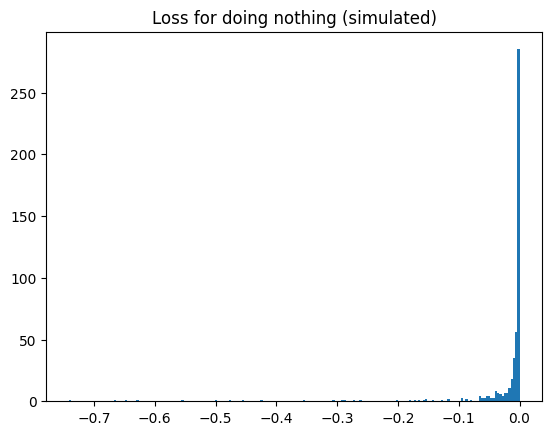

mean -0.025508836099201765
median -0.002425057241775617


In [23]:
def null_policy(_:Observation) -> Action:
    return Action(0, 0)

# test loss function
do_nothing_loss = []
for obs in idm_test_set:
    _, rew, _ = run_game(env, null_policy, obs)
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

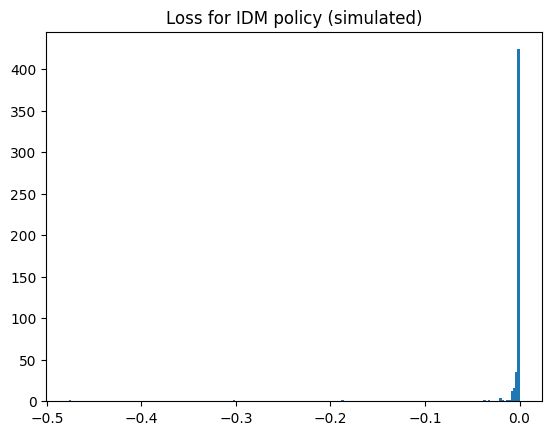

mean -0.0032415838164359815
median -9.599932889507501e-05


In [25]:
# test loss function
idm_loss = []
for o in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), o)
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

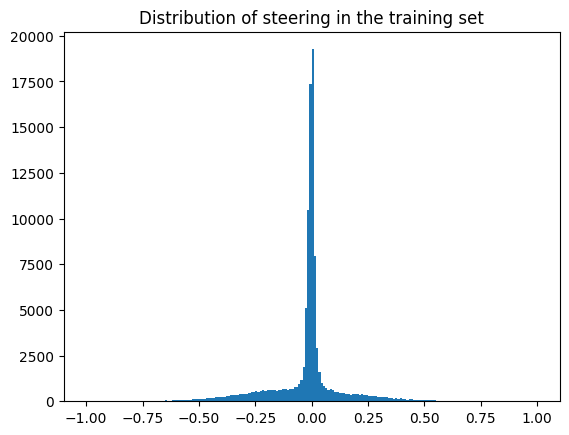

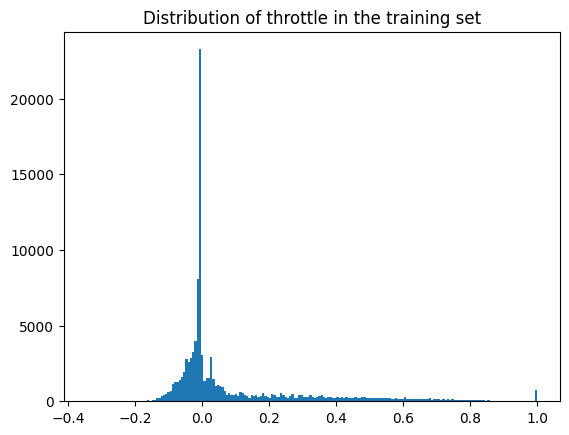

In [27]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()

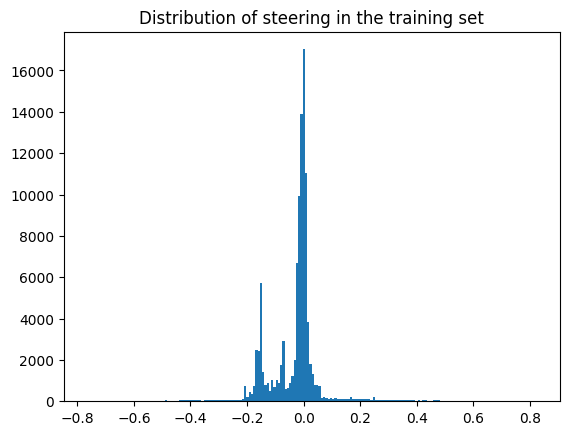

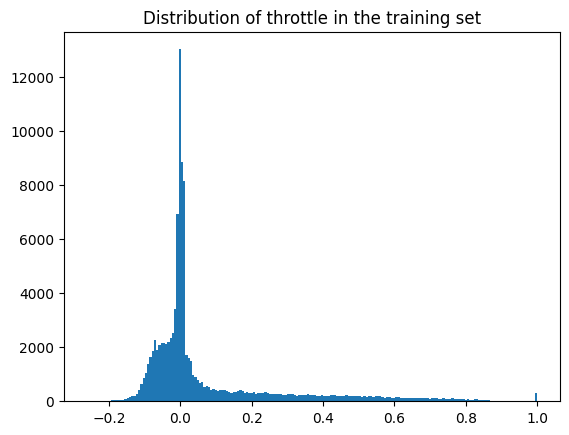

In [48]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()